In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

import time

from jax import numpy as jnp
from jax import random as jr
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
# import tensorflow as tf
# tf.test.gpu_device_name()

import gaussfiltax.utils as utils
import gaussfiltax.inference as gf
from gaussfiltax.inference import ParamsUKF
from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Parameters
state_dim = 4
state_noise_dim = 2
emission_dim = 1
emission_noise_dim = 1
seq_length = 30
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
# mu0 = jnp.ones(state_dim)
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-6 * jnp.eye(state_noise_dim)
R = 25*1e-6 * jnp.eye(emission_noise_dim)

dt = 0.5
FCV = jnp.array([[1, dt, 0, 0],[0, 1, 0, 0],[0, 0, 1, dt],[0, 0, 0, 1]])
acc = 0.5
Omega = lambda x, acc: 0.1 * acc / jnp.sqrt(x[1]**2 + x[3]**2)
FCT =  lambda x, a: jnp.array([[1, jnp.sin(dt * Omega(x, a)) / Omega(x, a), 0, -(1-jnp.cos(dt * Omega(x, a))) / Omega(x, a)],
                            [0, jnp.cos(dt * Omega(x, a)), 0, -jnp.sin(dt * Omega(x, a))],
                            [0, (1-jnp.cos(dt * Omega(x, a))) / Omega(x, a), 1, jnp.sin(dt * Omega(x, a)) / Omega(x, a)],
                            [0, jnp.sin(dt * Omega(x, a)), 0, jnp.cos(dt * Omega(x, a))]])

G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: FCV @ x + G @ q
fManBOT = lambda x, q, u: (0.5*(u-1)*(u-2)*FCV - u*(u-2)*FCT(x, acc) + 0.5*u*(u-1) * FCT(x, -acc)) @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT(x, 0.0, u), covariance_matrix = R).log_prob(y)
# inputs = jnp.zeros((seq_length, 1))
inputs = jnp.array([1]*int(seq_length/3) + [0]*int(seq_length/3) + [2]*int(seq_length/3)) # maneuver inputs

In [3]:
f = fManBOT
g = gBOT
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

In [ ]:
verbose = False
Nsim = 20
gsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
agsf_opt_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)
gsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
agsf_opt_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))
gsf_time = jnp.zeros(Nsim)
agsf_time = jnp.zeros(Nsim)
agsf_opt_time = jnp.zeros(Nsim)
bpf_time = jnp.zeros(Nsim)
next_key = jr.PRNGKey(1)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key0, key, next_key = jr.split(next_key, 3)
    print('key0: ', key0)
    print('key: ', key)
    states, emissions = model.sample(params, key0, seq_length, inputs = inputs)

    # GSF
    M = 5
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    t_gsf= tout - tin
    print('       Time taken for GSF: ', tout - tin)

    # AGSF
    opt_args = (0.1, 0.1)
    num_components = [M, 5, 5] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node

    tin = time.time()
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    t_agsf= tout - tin
    print('       Time taken for AGSF: ', tout - tin)


    # AGSF Optimal
    # tin = time.time()
    # posterior_filtered_agsf_opt, aux_outputs_opt = gf.augmented_gaussian_sum_filter_optimal(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    # point_estimate_agsf_opt = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf_opt.means, posterior_filtered_agsf_opt.weights), axis=0)
    # tout = time.time()
    # t_agsf_opt= tout - tin
    # print('       Time taken for AGSF optimal: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 100

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    t_bpf = tout - tin
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf, states))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf, states))
    # agsf_opt_rmse = agsf_opt_rmse.at[i].set(utils.rmse(point_estimate_agsf_opt, states))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf, states))

    print('              GSF RMSE:', gsf_rmse[i])                                                                           
    print('              AGSF RMSE:', agsf_rmse[i])
    # print('              AGSF Optimal RMSE:', agsf_opt_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])

    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf - states, axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf - states, axis = 1))
    # agsf_opt_norm = agsf_opt_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf_opt - states, axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf - states, axis = 1))

    gsf_time = gsf_time.at[i].set(t_gsf)
    agsf_time = agsf_time.at[i].set(t_agsf)
    # agsf_opt_time = agsf_opt_time.at[i].set(t_agsf_opt)
    bpf_time = bpf_time.at[i].set(t_bpf)

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
    # axes[0].scatter(point_estimate_agsf_opt[:,0], point_estimate_agsf_opt[:,2], label = 'AGSF-O', s = 4, marker= 'd')
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_agsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'AGSF')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
    axes[2].legend()

 

    plt.show()

In [6]:
ind = jnp.argwhere(jnp.isnan(gsf_rmse)).flatten()
gsf_rmse = jnp.delete(gsf_rmse, ind, axis = 0)

In [7]:
import pandas as pd
gsf_armse = jnp.mean(gsf_rmse)
agsf_armse = jnp.mean(agsf_rmse)
bpf_armse = jnp.mean(bpf_rmse)

gsf_atime = jnp.mean(gsf_time)
agsf_atime = jnp.mean(agsf_time)
bpf_atime = jnp.mean(bpf_time)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_rmse))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_rmse))
# agsf_opt_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_opt_armse, jnp.std(agsf_opt_rmse))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_rmse))

gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, jnp.std(gsf_time))
agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, jnp.std(agsf_time))
# agsf_opt_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_opt_atime, jnp.std(agsf_opt_time))
bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, jnp.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
# df[' '] = ['GSF', 'AGSF', 'AGSF Optimal', 'BPF']
# df['RMSE'] = [gsf_tab_out, agsf_tab_out, agsf_opt_tab_out, bpf_tab_out]
# df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, agsf_opt_tab_out1, bpf_tab_out1]
df[' '] = ['GSF', 'AGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, agsf_tab_out, bpf_tab_out]
df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))
df

\begin{tabular}{lll}
\toprule
  & RMSE & time(s) \\
\midrule
GSF &       0.45±      0.47 &       0.79±      0.16 \\
AGSF &       0.83±      0.55 &      16.72±      0.29 \\
BPF &       0.98±      0.65 &       0.55±      0.10 \\
\bottomrule
\end{tabular}



,,RMSE,time(s)
0,GSF,0.45± 0.47,0.79± 0.16
1,AGSF,0.83± 0.55,16.72± 0.29
2,BPF,0.98± 0.65,0.55± 0.10


0.8420097
0.12059625


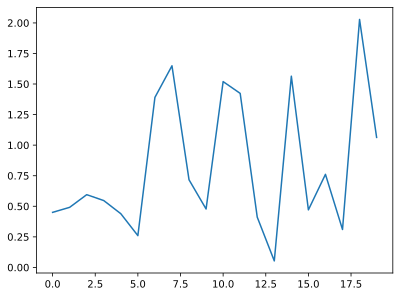

In [8]:
def bootstrap(key, rmse_array, B):
    N = rmse_array.shape[0]
    rmse_boot = jnp.zeros((B,))
    for b in range(B):
        key, subkey = jr.split(key)
        ind = jr.randint(subkey, (N,), 0, N)
        rmse_boot = rmse_boot.at[b].set(jnp.mean(rmse_array[ind]))
    return rmse_boot

agsf_boot = bootstrap(jr.PRNGKey(0), agsf_rmse, 100)
print(jnp.mean(agsf_boot))
print(jnp.std(agsf_boot))
plt.plot(agsf_rmse)
plt.show()


## Plots

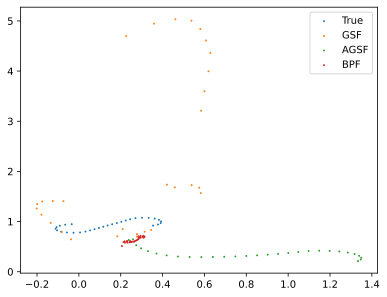

In [9]:
plt.scatter(states[:,0], states[:,2], label = 'True', s = 1)
plt.scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 1)
plt.scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 1)
plt.scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 1)
plt.legend()   
plt.show()